# Event-Related Analysis of Inter-Beat Interval Dynamics in the MID Task (Aligned to Target Onset)

### Loading packages

In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import sem
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

## This script has 150 time bins per trial aligned to the TARGET onset

## Required pre-processing steps before running this analysis script:

1. Download the DICOM files for the MID participant
2. Copy the necessary the Physio DICOM files to the correct DICOM preprocessing folder
    cd to /restricted/projectnb/cd-lab/yesh/physio/MID so that you are inside the MID directory:
   * run sh copy_physio_logs.sh ppt id [i.e. sh copy_physio_logs.sh 4115]

3. Run the MATLAB preprocessing script to extract the peak times column file, which is the necessary input for this script. 2 ways to run this.
    cd to /restricted/projectnb/cd-lab/yesh/physio/MID so that you are inside the MID directory:
    * then you can use module load matlab > process_physio(participant id) [i.e. process_physio(4115)]
    * OR you can use module load matlab > matlab -batch > "process_physio(4115)"
4. Upload the csv file to /restricted/projectnb/cd-lab/yesh/physio/MID/CSVs


## Loading physiological and CSV data

In [399]:
participants = ["4111", "4112", "4113", "4114", "4115", "4117", "4120", "4125", "4127", "4121", "4142", "4139", "4148", "4145", "4152", "4149", "4103",
               "4156", "4160", "4157", "4159"]  

In [400]:
base_path="/restricted/projectnb/cd-lab/yesh/physio/MID"
participant_path = f"{base_path}/Physio_outputs/p{participants}"
peak_base=participant_path
base_dir = "/restricted/projectnb/cd-lab/yesh/physio/MID/DICOMS"
csv_base = "/restricted/projectnb/cd-lab/yesh/physio/MID/CSVs"

In [401]:
def load_data(csv_path):
    data = pd.read_csv(csv_path)
    cleaned = data[data["EarlyHit"] == 0].reset_index(drop=True)
    return cleaned

In [402]:
def load_peak_times(base_path, n_runs=4):
    peak_times = []
    for run in range(1, n_runs + 1):
        file_path = os.path.join(base_path, f"peakTimes_PPG_Siemens_col_r{run}.txt")
        print(f"Loading: {file_path}")  # Debug print
        peak_times.append(np.loadtxt(file_path))
    return peak_times


In [403]:
def extract_cue_times(data_csv, n_runs=4):
    cue_times = []
    for run in range(1, n_runs + 1):
        run_cues = data_csv.loc[data_csv["RunNumber"] == run, "TargetOnset"].values
        cue_times.append(run_cues)
    return cue_times


In [404]:
def extract_event_aligned_ibi(peak_times, cue_times, bin_centers):
    ibi_values = np.diff(peak_times)
    ibi_times = peak_times[:-1]
    n_bins = len(bin_centers)
    
    all_trials_ibi = []
    for cue in cue_times:
        bin_times = cue + bin_centers
        trial_ibi = np.full(n_bins, np.nan)
        for i, t in enumerate(bin_times):
            idx = np.searchsorted(ibi_times, t, side='right') - 1
            if 0 <= idx < len(ibi_values):
                trial_ibi[i] = ibi_values[idx]
        all_trials_ibi.append(trial_ibi)
    return np.array(all_trials_ibi) 
    #returns an IBI matrix for EACH run 
    


In [405]:
def plot_trials(ibi_matrix, bin_centers, run_number, n_to_plot=5):
    plt.figure(figsize=(10, 5))
    for i in range(n_to_plot):
        plt.plot(bin_centers, ibi_matrix[i], label=f'Trial {i+1}')
    plt.axvline(0, color='red', linestyle='--', label='Cue Onset')
    plt.xlabel("Time (s) from target onset")
    plt.ylabel("IBI (s)")
    plt.title(f"IBI around Target Onset (Run {run_number}, First {n_to_plot} Trials)")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Code blocks for grouping and plotting different trial types

In [406]:
def annotate_event_timeline():
    #Potential Cue Presentation 
    #plt.axvspan(-7, -1, color="lightblue", alpha=0.2, label="Potential Cue Presentation")

    #Potential Fixation Period
    plt.axvline(-5, color="mediumseagreen", linestyle="--", label="Potential Fixation Period")
    plt.axvline(0, color="mediumseagreen", linestyle="--", label="Potential Fixation Period")
    plt.axvspan(-1,0, color="mediumseagreen", alpha=0.2, label="Gauranteed 1s Fixation Period")
    
    # Target onset and offset
    plt.axvspan(0, 1, color="yellow", alpha=0.2, label="Target Window")
    #plt.axvline(0, color="red", linestyle="--", label="Target Window Onset")
    #plt.axvline(1, color="red", linestyle="--", label="Target Window Offset")

    # Feedback onset and offset 
    plt.axvspan(1, 3, color="mediumorchid", alpha=0.2, label="Feedback Window")
    # plt.axvline(1.04, color="green", linestyle="--", label="Feedback Onset")
    # plt.axvline(3, color="green", linestyle="--", label="Feedback Offset")

    # ITI
    plt.axvline(3, color="dimgray", linestyle="--", label="ITI Range")
    plt.axvline(9, color="dimgray", linestyle="--", label="ITI Range")
    plt.axvspan(3,5, color="darkgray", alpha=0.2, label="Gauranteed 2s ITI Period")


In [407]:
def plot_average_ibi_across_runs(all_runs, bin_centers):

    colors = ["blue", "green", "orange", "purple"]
    labels = [f"Run {i+1}" for i in range(len(all_runs))]

    plt.figure(figsize=(10, 5))

    for i, run_data in enumerate(all_runs):
       
        mean_ibi = np.nanmean(run_data, axis=0)

        plt.plot(bin_centers, mean_ibi, label=labels[i], color=colors[i % len(colors)])

    annotate_event_timeline()

    #plt.ylim(1.2, 1.36)
    plt.xlabel("Time (s) relative to target")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI Across Runs")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [408]:
def plot_ibi_average(all_ibi_task, bin_centers):
    plt.figure(figsize=(10,5))
    mean_ibi_task=np.nanmean(all_ibi_task, axis=0)

    plt.plot(bin_centers,mean_ibi_task,label="Mean IBI", color="gray")
    annotate_event_timeline()

    #plt.ylim(1.2, 1.36)
    plt.xlabel("Time (s) relative to target")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI Across Task")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [409]:
def gainorloss(cleaned, all_ibi_task):
    loss_range=(1,5)
    gain_range=(6,10)

    #grab the indices of the gain and loss trials from the data csv 
    potential_loss=cleaned[cleaned['CueType'].between(loss_range[0],loss_range[1])]
    potential_gain=cleaned[cleaned['CueType'].between(gain_range[0],gain_range[1])]

    #convert the index into an integer
    loss_indices = potential_loss.index.to_numpy()
    gain_indices = potential_gain.index.to_numpy()
    
    #Index out the loss and gain trials
    loss_trials=all_ibi_task[loss_indices]
    gain_trials=all_ibi_task[gain_indices]

    #Compute the mean for each group
    mean_ibi_loss = np.nanmean(loss_trials, axis=0)
    mean_ibi_gain = np.nanmean(gain_trials, axis=0)

    return mean_ibi_loss,mean_ibi_gain, loss_trials, gain_trials


In [410]:
def plot_gain_loss(mean_ibi_loss,mean_ibi_gain,bin_centers):
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, mean_ibi_loss, label="Potential Loss", color="red")
    plt.plot(bin_centers, mean_ibi_gain, label="Potential Gain", color="green")

    annotate_event_timeline()


    #Labels and formatting 
    plt.xlabel("Time (s) relative to target")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI around Target Presentation Across Runs (Potential Loss vs Potential Gain)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [411]:
def smallorlarge(cleaned, all_ibi_task):
   
    #grab the indices of the small and large trials from the data csv 
    large_cue=cleaned[cleaned['CueType'].isin([4,5,9, 10])]
    small_cue=cleaned[cleaned['CueType'].isin([1,2,6,7])]

    #convert the index into an integer
    large_indices = large_cue.index.to_numpy()
    small_indices = small_cue.index.to_numpy()
    
    #Index out the small and large trials
    large_trials=all_ibi_task[large_indices]
    small_trials=all_ibi_task[small_indices]

    #Compute the mean for each group
    mean_ibi_large = np.nanmean(large_trials, axis=0)
    mean_ibi_small = np.nanmean(small_trials, axis=0)

    return mean_ibi_large,mean_ibi_small, large_trials, small_trials


In [412]:
def plot_small_large(mean_ibi_large,mean_ibi_small,bin_centers):
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, mean_ibi_large, label="Large Cue", color="blue")
    plt.plot(bin_centers, mean_ibi_small, label="Small Cue", color="lightblue")


    annotate_event_timeline()


    #Labels and formatting 
    plt.xlabel("Time (s) relative to target")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI around Target Presentation Across All Runs (Large vs Small Cue)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [413]:
def assign_magnitude(cleaned, all_ibi_task):
    #grabbing the indicides of each magnitude level
    mag1=cleaned[cleaned['CueType'].isin([1, 6])]
    mag3=cleaned[cleaned['CueType'].isin([2, 7])]
    mag5=cleaned[cleaned['CueType'].isin([3, 8])]
    mag7=cleaned[cleaned['CueType'].isin([4, 9])]
    mag9=cleaned[cleaned['CueType'].isin([5, 10])]

    #converting the indices into an integer
    mag1_indices=mag1.index.to_numpy()
    mag3_indices=mag3.index.to_numpy()
    mag5_indices=mag5.index.to_numpy()
    mag7_indices=mag7.index.to_numpy()
    mag9_indices=mag9.index.to_numpy()

    #index out all the small and large trials 
    mag1_trials=all_ibi_task[mag1_indices]
    mag3_trials=all_ibi_task[mag3_indices]
    mag5_trials=all_ibi_task[mag5_indices]
    mag7_trials=all_ibi_task[mag7_indices]
    mag9_trials=all_ibi_task[mag9_indices]

    
    mean_ibi_mag1=np.nanmean(mag1_trials, axis=0)
    mean_ibi_mag3=np.nanmean(mag3_trials, axis=0)
    mean_ibi_mag5=np.nanmean(mag5_trials, axis=0)
    mean_ibi_mag7=np.nanmean(mag7_trials, axis=0)
    mean_ibi_mag9=np.nanmean(mag9_trials, axis=0)


    return mean_ibi_mag1,mean_ibi_mag3,mean_ibi_mag5,mean_ibi_mag7,mean_ibi_mag9
    

In [414]:
def plot_magnitudes(mean_ibi_mag1, mean_ibi_mag3, mean_ibi_mag5, mean_ibi_mag7, mean_ibi_mag9, bin_centers):
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, mean_ibi_mag1, label="+/- $1", color="red")
    plt.plot(bin_centers, mean_ibi_mag3, label="+/- $3", color="orange")
    plt.plot(bin_centers, mean_ibi_mag5, label="+/- $5", color="green")
    plt.plot(bin_centers, mean_ibi_mag7, label="+/- $7", color="blue")
    plt.plot(bin_centers, mean_ibi_mag9, label="+/- $9", color="hotpink")

    annotate_event_timeline()

     #Labels and formatting 
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI around Cue Presentation Across Runs (Per Cue Magnitude)")
    plt.legend()
    plt.tight_layout()
    plt.show()    

In [415]:
def pos_or_neg_feedback(cleaned, all_ibi_task):
    #grab the indices of the positive and negative feedback trials from the data csv
    pos_feedback=cleaned[cleaned['IsWin']==1]
    neg_feedback=cleaned[cleaned['IsWin']==0]

    #convert the index into an integer
    pos_indices = pos_feedback.index.to_numpy()
    neg_indices = neg_feedback.index.to_numpy()
    
    #Index out the small and large trials
    posfeedback_trials=all_ibi_task[pos_indices]
    negfeedback_trials=all_ibi_task[neg_indices]

    #Compute the mean for each group
    mean_ibi_posfeedback = np.nanmean(posfeedback_trials, axis=0)
    mean_ibi_negfeedback = np.nanmean(negfeedback_trials, axis=0)

    return mean_ibi_posfeedback,mean_ibi_negfeedback, posfeedback_trials, negfeedback_trials
    

In [416]:
def plot_pos_neg(mean_ibi_posfeedback, mean_ibi_negfeedback, bin_centers):
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, mean_ibi_posfeedback, label="Positive Feedback", color="orange")
    plt.plot(bin_centers, mean_ibi_negfeedback, label="Negative Feedback", color="red")

    annotate_event_timeline()

    #Labels and formatting 
    plt.xlabel("Time (s) relative to cue")
    plt.ylabel("IBI (s)")
    plt.title("Average IBI Following Target Presentation Across All Runs (Hit vs Miss Feedback)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Pipeline to plot the following trials for an individual participant:
* individual trial timecoures of n trials
* average IBI timecourse plotted separately for each of the 4 runs
* average IBI timecourse across all trials in the task (aligned to cue presentation)
* average IBI timecourse across task for cues that indicate the opportunity to win money vs the opportunity to lose money
* average IBI timecourse across task for small cues (opportunity to win/lose 1 dollar or 3 dollars) vs large cues (opportunity to win/lose 5 dollars or 7 dollars)
* average IBI timecourse across task for a trial successfully "hit" vs "missed" 
* average IBI timecourse across task for the parametric magnitudes all plotted individually (+/- 1 dollar, 3 dollars, 5 dollars, 7 dollars, 9 dollars)

In [417]:
def run_pipeline_single(csv_path, peak_times_dir, plot_run=None, plot_n_trials=5, plot_group_average=True, plot_task_average=True, plot_gainloss=True, plot_smalllarge=True, plot_magnitudes_flag=True, plot_hitmiss_flag=True):
    bin_edges = np.arange(-5.0, 10.0 + 0.1, 0.1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    data = load_data(csv_path)
    peak_times_all = load_peak_times(peak_times_dir)
    cue_times_all = extract_cue_times(data)

    #creates a list of arrays, where each array corresponds to one run
    all_ibi_runs = []
    for r in range(len(peak_times_all)):
        #returns one run's IBI matrix per run 
        run_ibi = extract_event_aligned_ibi(peak_times_all[r], cue_times_all[r], bin_centers)
        all_ibi_runs.append(run_ibi)
    #creates a single 2d array combining all runs' trials vertically (the shape is [total trials across all runs, n_bins]
    
    all_ibi_task=np.vstack(all_ibi_runs)

    if plot_run is not None:
        plot_trials(all_ibi_runs[plot_run - 1], bin_centers, plot_run, n_to_plot=plot_n_trials)

    if plot_group_average:
        plot_average_ibi_across_runs(all_ibi_runs, bin_centers)

    if plot_task_average:
        plot_ibi_average(all_ibi_task, bin_centers)

    if plot_gainloss:
        mean_ibi_loss, mean_ibi_gain, loss_trials, gain_trials = gainorloss(data, all_ibi_task)
        plot_gain_loss(mean_ibi_loss,mean_ibi_gain,bin_centers)

    if plot_smalllarge:
        mean_ibi_large,mean_ibi_small, large_trials, small_trials = smallorlarge(data,all_ibi_task)
        plot_small_large(mean_ibi_large,mean_ibi_small,bin_centers)

    if plot_magnitudes_flag:
        mean_ibi_mag1, mean_ibi_mag3, mean_ibi_mag5, mean_ibi_mag7, mean_ibi_mag9 = assign_magnitude(data, all_ibi_task)
        plot_magnitudes(mean_ibi_mag1, mean_ibi_mag3, mean_ibi_mag5, mean_ibi_mag7, mean_ibi_mag9, bin_centers)

    if plot_hitmiss_flag:
        mean_ibi_posfeedback, mean_ibi_negfeedback, posfeedback_trials, negfeedback_trials=pos_or_neg_feedback(data, all_ibi_task)
        plot_pos_neg(mean_ibi_posfeedback, mean_ibi_negfeedback, bin_centers)



    return all_ibi_runs, bin_centers

## Example of running the pipeline for individual participant

Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4125/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4125/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4125/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4125/peakTimes_PPG_Siemens_col_r4.txt


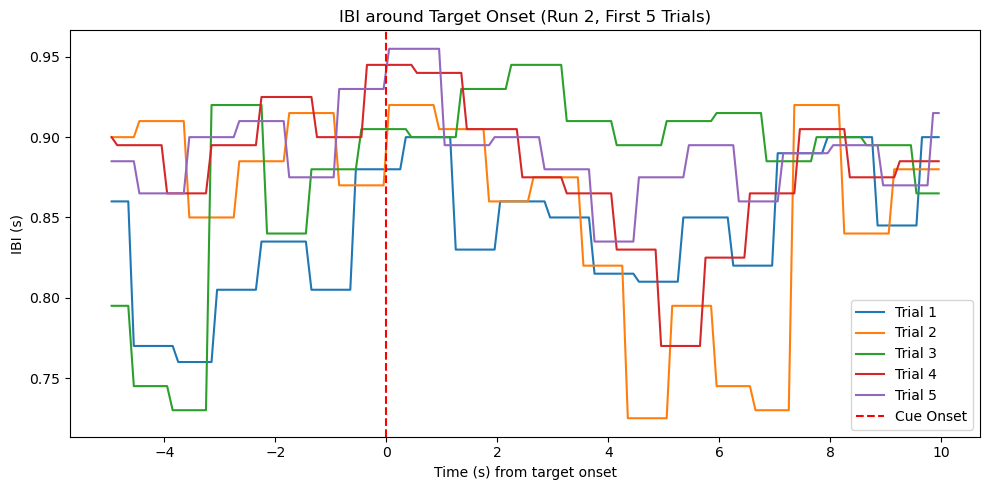

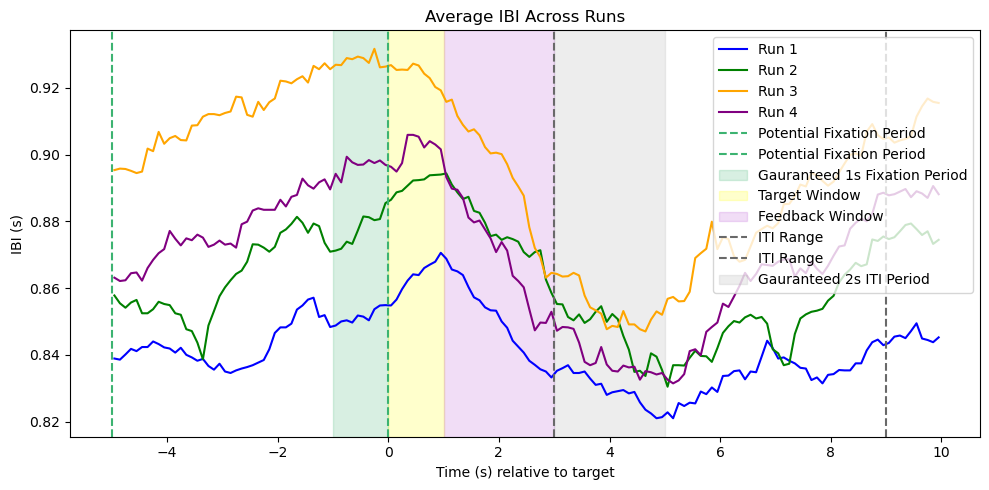

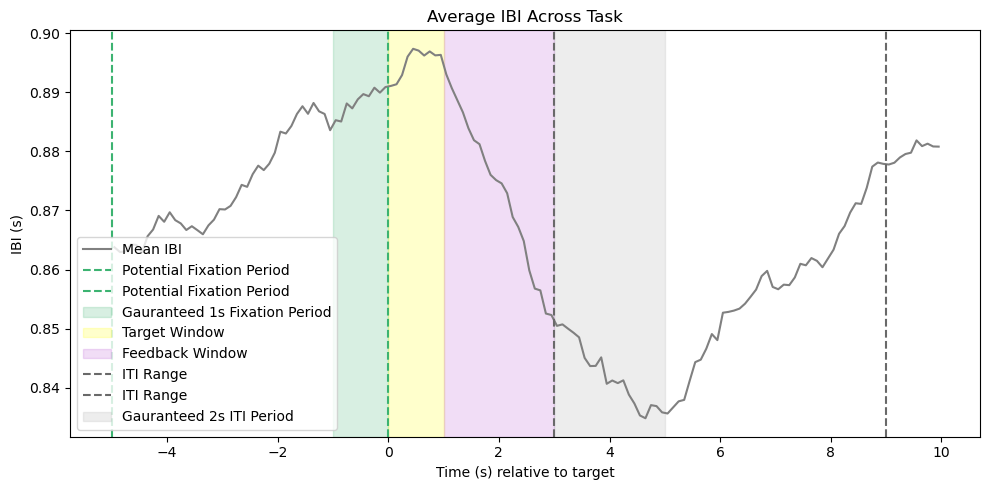

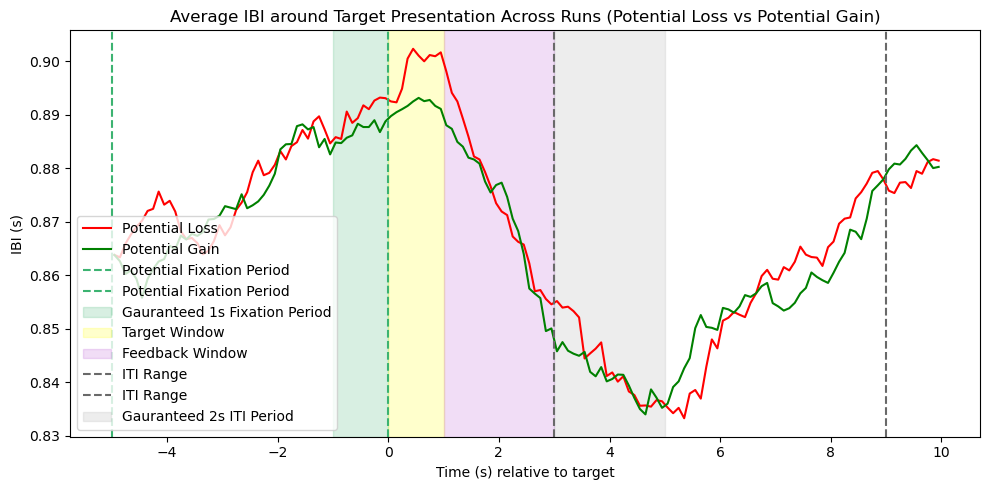

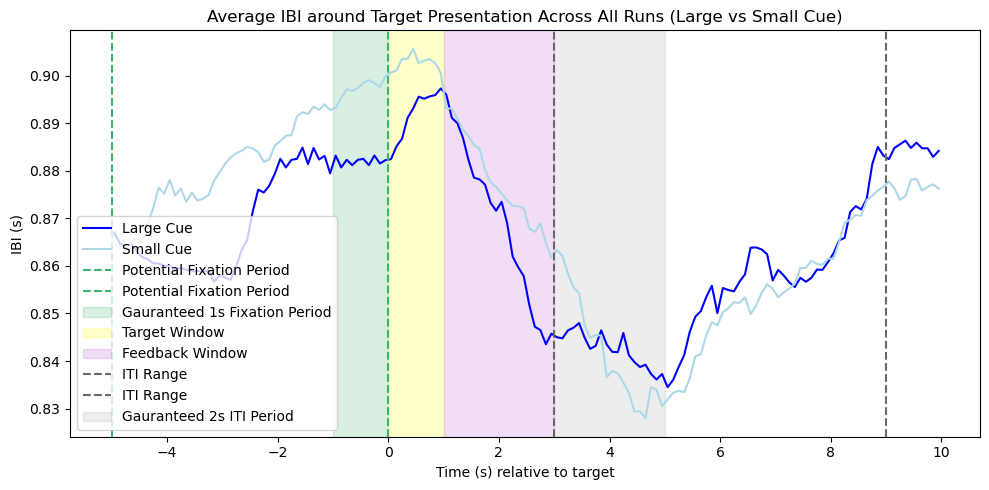

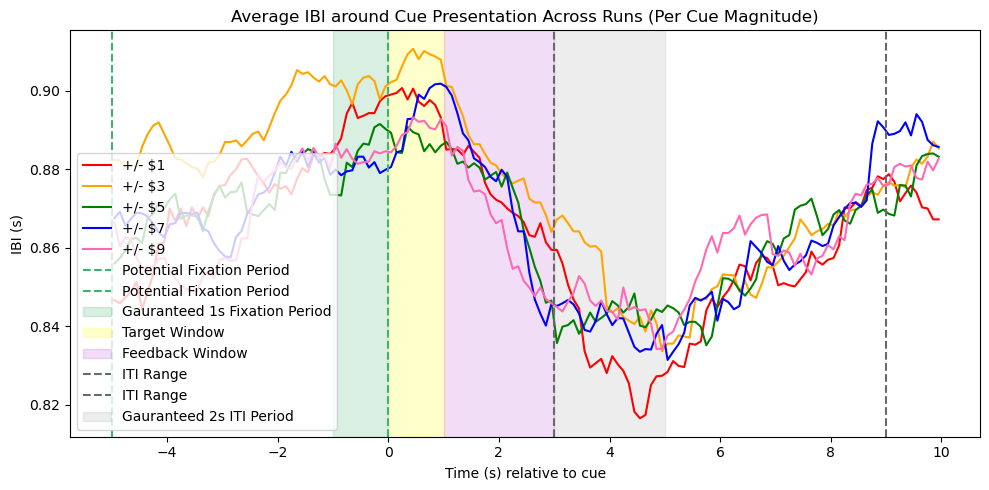

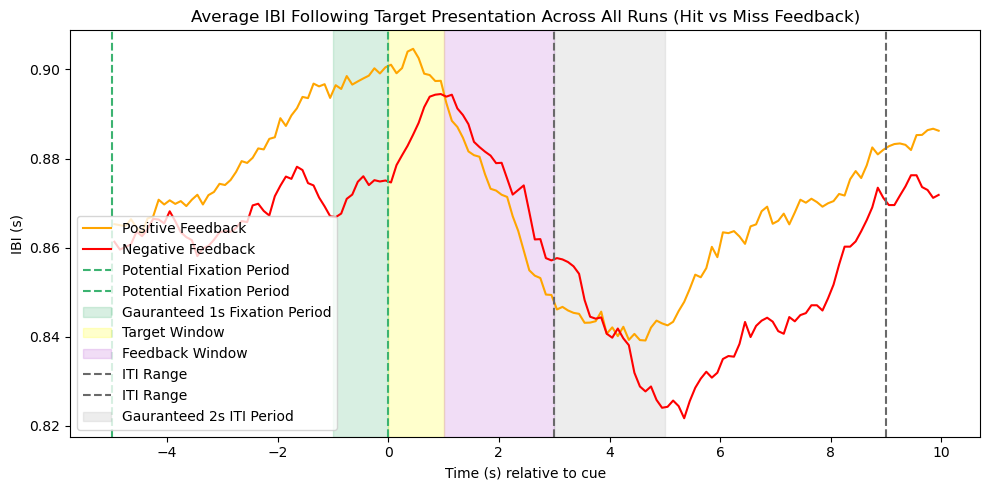

In [418]:
ppt="4125"

#Construct paths 
base_path="/restricted/projectnb/cd-lab/yesh/physio/MID"
participant_path = f"{base_path}/Physio_outputs/p{ppt}"
csv_file=f"{base_path}/CSVs/p{ppt}_data.csv"
peak_dir=participant_path

ibi_data, bins = run_pipeline_single(csv_file, peak_dir, plot_run=2)


## Incorporating participant-specific baselines for the group analyses
In order to more meaninfully compare IBI timecourses across participants, participants' IBI time coureses were expressed as %change from their baseline IBI across the entire task

In [419]:
def normalize_ibi_percent_change(all_participant_ibi):
    normalized_all= []
    for ibi_data in all_participant_ibi:
        #calculates the overall mean IBI per participant
        participant_mean=np.nanmean(ibi_data)

        #compute mean across trials at each bin
        mean_ibi=np.nanmean(ibi_data, axis=0)

        #percent change relative to overall mean
        percent_change = ((mean_ibi - participant_mean) / participant_mean) * 100

        normalized_all.append(percent_change)
    
    return normalized_all

        

## Plotting Code for Group-Level Analyses

In [420]:
#originally named plot_avg_runs_across_participants
def is_consistent_across_runs(all_ibi_runs_by_participant, bin_centers, participant_means, participants):
    """
    Plot the average normalized IBI timecourse for each run, averaged across all participants.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    n_runs = len(all_ibi_runs_by_participant[0])  # assuming each participant has same number of runs
    colors = ['blue', 'orange', 'green', 'purple']  # one color per run

    # Collect normalized runs for each run index
    runs_norm_all_participants = [[] for _ in range(n_runs)]

    for i, participant_runs in enumerate(all_ibi_runs_by_participant):
        baseline = participant_means[participants[i]]
        for run_idx in range(n_runs):
            run = participant_runs[run_idx]
            run_avg = np.nanmean(run, axis=0)
            run_norm = ((run_avg - baseline) / baseline) * 100
            runs_norm_all_participants[run_idx].append(run_norm)

    # Compute mean across participants for each run
    mean_runs = [np.nanmean(runs_norm_all_participants[run_idx], axis=0) for run_idx in range(n_runs)]

    plt.figure(figsize=(10,5))
    for run_idx in range(n_runs):
        plt.plot(bin_centers, mean_runs[run_idx], color=colors[run_idx % len(colors)], label=f'Run {run_idx+1}')

    # Legend
    legend_elements = [
    Line2D([0], [0], color="black", lw=3, label="Group Average"),

    Line2D([0], [0], color="mediumseagreen", linestyle="--", label="Potential Fixation Period"),
    Patch(facecolor="mediumseagreen", alpha=0.2, label="Guaranteed 1s Fixation Period"),

    Patch(facecolor="yellow", alpha=0.2, label="Target Window"),

    Patch(facecolor="mediumorchid", alpha=0.2, label="Feedback Window"),

    Line2D([0], [0], color="dimgray", linestyle="--", label="ITI Range"),
    Patch(facecolor="lightgray", alpha=0.2, label="Guaranteed 2s ITI Period"),
]

    annotate_event_timeline()
    plt.title('Average Normalized IBI Timecourse per Run Across Participants (Aligned to Target Onset)')
    plt.xlabel("Time (s) relative to target")
    plt.ylabel("IBI (% change from person-specific mean)")
    plt.legend(handles=legend_elements)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("4runs_target.png", dpi=300, bbox_inches='tight')
    plt.show()


In [421]:

# def plot_group_average_per_run(all_ibi_runs_by_participant, bin_centers):
#     """
#     Plots one line per run (Run 1 to Run 4), showing the group average IBI across all participants.
#     Each run is averaged across all participants.
#     """
#     n_runs = len(all_ibi_runs_by_participant[0])
#     run_avg_list = [[] for _ in range(n_runs)]  # will hold all participants' run averages

#     # Collect per-run averages from each participant
#     for participant_runs in all_ibi_runs_by_participant:
#         for run_idx in range(n_runs):
#             run = participant_runs[run_idx]  # shape: [n_trials, n_bins]
#             run_avg = np.nanmean(run, axis=0)  # average over trials for this run
#             run_avg_list[run_idx].append(run_avg)

#     # Plot all runs on the same figure
#     plt.figure(figsize=(10, 6))
#     colors = ['blue', 'orange', 'green', 'purple']
#     for run_idx, run_data in enumerate(run_avg_list):
#         run_stack = np.vstack(run_data)  # shape: [n_participants, n_bins]
#         run_mean = np.nanmean(run_stack, axis=0)
#         run_se = sem(run_stack, axis=0, nan_policy='omit')

#         color = colors[run_idx % len(colors)]
#         plt.plot(bin_centers, run_mean, label=f'Run {run_idx+1}', color=color)
#         plt.fill_between(bin_centers, run_mean - run_se, run_mean + run_se, alpha=0.2, color=color)

#     plt.title("Group-Averaged IBI for Each Run")
#     plt.xlabel("Time (s) relative to target")
#     plt.ylabel("IBI (ms)")
#     plt.axhline(0, color='gray', linestyle='--')
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig("4runs.png", dpi=300, bbox_inches='tight')
#     plt.show()


In [422]:
# def plot_average_ibi_all_participants(all_participant_ibi, bin_centers, participants):
#     # Use normalized percent change
#     normalized_all = normalize_ibi_percent_change(all_participant_ibi)
    
#     plt.figure(figsize=(10, 5))
#     for i, percent_change in enumerate(normalized_all):
#         plt.plot(bin_centers, percent_change, label=f"Participant {participants[i]}")
    
#     annotate_event_timeline()
#     plt.xlabel("Time (s) relative to target")
#     plt.ylabel("IBI (% change from person-specific mean)")
#     plt.title("Normalized IBI (% Change) Across Participants")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

In [423]:
#originally named plot_average_ibi_all_participants_with_group_avg

def what_shape_cue_presentation(all_participant_ibi, bin_centers, participants):
    # Normalize individual participants' IBI as percent change
    normalized_all = normalize_ibi_percent_change(all_participant_ibi)
    
    plt.figure(figsize=(10, 5))
    
    # Plot each participant's normalized IBI
    for i, percent_change in enumerate(normalized_all):
        plt.plot(bin_centers, percent_change, label=f"Participant {participants[i]}", alpha=0.6)
    
    # Compute grand average across participants (average over all normalized timecourses)
    group_avg = np.nanmean(normalized_all, axis=0)
    
    # Plot the grand average with a thicker line and distinct color
    plt.plot(bin_centers, group_avg, color='black', lw=3, label='Group Average')

    legend_elements = [
    Line2D([0], [0], color="black", lw=3, label="Group Average"),

    Line2D([0], [0], color="mediumseagreen", linestyle="--", label="Potential Fixation Period"),
    Patch(facecolor="mediumseagreen", alpha=0.2, label="Guaranteed 1s Fixation Period"),

    Patch(facecolor="yellow", alpha=0.2, label="Target Window"),

    Patch(facecolor="mediumorchid", alpha=0.2, label="Feedback Window"),

    Line2D([0], [0], color="dimgray", linestyle="--", label="ITI Range"),
    Patch(facecolor="lightgray", alpha=0.2, label="Guaranteed 2s ITI Period"),
]
    
    annotate_event_timeline()
    plt.xlabel("Time (s) relative to target presentation")
    plt.ylabel("IBI (% change from person-specific mean)")
    plt.title("Normalized IBI (% Change) Across Participants (Aligned to Target Onset)")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
    plt.legend(handles=legend_elements, loc="lower left", fontsize='small')
    plt.tight_layout()
    plt.savefig("ibi_group_target.png", dpi=300, bbox_inches='tight')  # <--- Save the figure
    plt.show()


In [424]:
# def plot_average_ibi_across_runs(all_runs, bin_centers, participant_mean=None, participant_id=None):

#     colors = ["blue", "green", "orange", "purple"]
#     labels = [f"Run {i+1}" for i in range(len(all_runs))]

#     plt.figure(figsize=(10, 9))

#     for i, run_data in enumerate(all_runs):
#         mean_ibi = np.nanmean(run_data, axis=0)

#         if participant_mean is not None:
#             # Normalize to % change from participant_mean
#             mean_ibi = ((mean_ibi - participant_mean) / participant_mean) * 100
        
#         plt.plot(bin_centers, mean_ibi, label=labels[i], color=colors[i % len(colors)])

#         if participant_id is not None and participant_mean is not None:
#             print(f"{participant_id} baseline: {participant_mean:.3f}")
#             print(f"{labels[i]} raw mean IBI [0:5]: {np.nanmean(run_data, axis=0)[:5]}")
#             print(f"{labels[i]} normalized mean IBI [0:5]: {mean_ibi[:5]}")

#     annotate_event_timeline()

#     plt.xlabel("Time (s) relative to target")
#     ylabel = "IBI (% change from participant mean)" if participant_mean is not None else "IBI (s)"
#     plt.ylabel(ylabel)
#     plt.title("Average IBI Across Runs")
#     plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
#     #plt.legend()
#     plt.tight_layout()
#     plt.show()


In [425]:
#previously named plot_group_gain_vs_loss
def is_difference_gain_vs_loss(mean_loss_list, mean_gain_list, bin_centers, participants):
    """
    Plots the average IBI timecourse across all participants for gain and loss trials,
    including shaded standard error bands.
    """
    try:
        
        gain_stack = np.vstack(mean_gain_list)
        loss_stack = np.vstack(mean_loss_list)

        
        gain_mean = np.nanmean(gain_stack, axis=0)
        gain_se = sem(gain_stack, axis=0, nan_policy='omit')

        loss_mean = np.nanmean(loss_stack, axis=0)
        loss_se = sem(loss_stack, axis=0, nan_policy='omit')

        plt.figure(figsize=(10, 5))
        plt.plot(bin_centers, gain_mean, label='Potential Gain Trials', color='green')
        plt.fill_between(bin_centers, gain_mean - gain_se, gain_mean + gain_se, alpha=0.3, color='green')

        plt.plot(bin_centers, loss_mean, label='Potential Loss Trials', color='red')
        plt.fill_between(bin_centers, loss_mean - loss_se, loss_mean + loss_se, alpha=0.3, color='red')

        annotate_event_timeline()
        plt.xlabel("Time (s) relative to target")
        plt.ylabel('IBI (% change from baseline)')
        plt.title(f'Group-Averaged IBI: Gain vs. Loss Trials (Aligned to Target Onset)\n(n={len(participants)} participants)')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
        plt.legend(ncols=2, loc="lower left", fontsize='small')
        plt.tight_layout()
        plt.savefig("gainvsloss_target.png", dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error in is_difference_gain_vs_loss: {e}")


In [426]:
#previously named plot_group_small_vs_large
def is_difference_small_vs_large(mean_large_list, mean_small_list, bin_centers, participants):
    """
    Plots the average IBI timecourse across all participants for small and large trials,
    including shaded standard error bands.
    """
    try:
        small_stack = np.vstack(mean_small_list)
        large_stack = np.vstack(mean_large_list)

        small_mean = np.nanmean(small_stack, axis=0)
        small_se = sem(small_stack, axis=0, nan_policy='omit')

        large_mean = np.nanmean(large_stack, axis=0)
        large_se = sem(large_stack, axis=0, nan_policy='omit')

      


        plt.figure(figsize=(10, 5))
        plt.plot(bin_centers, small_mean, label='Small Trials', color='dodgerblue')
        plt.fill_between(bin_centers, small_mean - small_se, small_mean + small_se, alpha=0.3, color='dodgerblue')

        plt.plot(bin_centers, large_mean, label='Large Trials', color='darkblue')
        plt.fill_between(bin_centers, large_mean - large_se, large_mean + large_se, alpha=0.3, color='darkblue')

        annotate_event_timeline()
        plt.xlabel("Time (s) relative to cue")
        plt.ylabel('IBI (% change from baseline)')
        plt.title(f'Group-Averaged IBI: Small vs. Large Trials (Aligned to Target Onset)\n(n={len(participants)} participants)')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
        plt.legend(ncols=2, loc='upper right', fontsize='small')
        plt.tight_layout()
        plt.savefig("smallvslarge_target.png", dpi=300, bbox_inches='tight')  # <--- Save the figure

        plt.show()
    except Exception as e:
        print(f"Error in is_difference_gain_vs_loss: {e}")


In [427]:
#previously named plot_group_posf_vs_negf
def is_difference_hit_miss(mean_posfeedback_list, mean_negefeedback_list, bin_centers, participants):
    """
    Plots the average IBI timecourse across all participants for win feedback trials and loss feedback trials,
    including shaded standard error bands.
    """
    try:
        pos_stack = np.vstack(mean_posfeedback_list)
        neg_stack = np.vstack(mean_negefeedback_list)

        pos_mean = np.nanmean(pos_stack, axis=0)
        pos_se = sem(pos_stack, axis=0, nan_policy='omit')

        neg_mean = np.nanmean(neg_stack, axis=0)
        neg_se = sem(neg_stack, axis=0, nan_policy='omit')

      


        plt.figure(figsize=(10, 5))
        plt.plot(bin_centers, pos_mean, label='Hit Trials', color='orange')
        plt.fill_between(bin_centers, pos_mean - pos_se, pos_mean + pos_se, alpha=0.3, color='orange')

        plt.plot(bin_centers, neg_mean, label='Miss Trials', color='purple')
        plt.fill_between(bin_centers, neg_mean - neg_se, neg_mean + neg_se, alpha=0.3, color='purple')

        annotate_event_timeline()
        plt.xlabel("Time (s) relative to target")
        plt.ylabel('IBI (% change from baseline)')
        plt.title(f'Group-Averaged IBI: Hit vs. Miss Trials Aligned to Target Onset\n(n={len(participants)} participants)')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
        plt.legend(ncols=2, loc="lower left", fontsize='small')
        plt.tight_layout()
        plt.savefig("posvsneg_target.png", dpi=300, bbox_inches='tight')  # <--- Save the figure

        plt.show()
    except Exception as e:
        print(f"Error in is_difference_gain_vs_loss: {e}")


In [428]:
# def plot_group_posfeedback_vs_negfeedack(mean_large_list, mean_small_list, bin_centers, participants):
#     """
#     Plots the average IBI timecourse across all participants for small and large trials,
#     including shaded standard error bands.
#     """
#     try:
#         small_stack = np.vstack(mean_small_list)
#         large_stack = np.vstack(mean_large_list)

#         small_mean = np.nanmean(small_stack, axis=0)
#         small_se = sem(small_stack, axis=0, nan_policy='omit')

#         large_mean = np.nanmean(large_stack, axis=0)
#         large_se = sem(large_stack, axis=0, nan_policy='omit')

      


#         plt.figure(figsize=(10, 5))
#         plt.plot(bin_centers, small_mean, label='Small Trials', color='dodgerblue')
#         plt.fill_between(bin_centers, small_mean - small_se, small_mean + small_se, alpha=0.3, color='dodgerblue')

#         plt.plot(bin_centers, large_mean, label='Large Trials', color='darkblue')
#         plt.fill_between(bin_centers, large_mean - large_se, large_mean + large_se, alpha=0.3, color='darkblue')

#         annotate_event_timeline()
#         plt.xlabel("Time (s) relative to target")
#         plt.ylabel('IBI (% change from baseline)')
#         plt.title(f'Group-Averaged IBI: Small vs. Large Trials\n(n={len(participants)} participants)')
#         plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
#         plt.legend()
#         plt.tight_layout()
#         #plt.savefig("normalized_ibi_plot.png", dpi=300, bbox_inches='tight')  # <--- Save the figure

#         plt.show()
#     except Exception as e:
#         print(f"Error in is_difference_gain_vs_loss: {e}")


In [429]:
# def plot_group_magnitudes(mean_ibi_mag1_list_norm, mean_ibi_mag3_list_norm, mean_ibi_mag5_list_norm, mean_ibi_mag7_list_norm, mean_ibi_mag9_list_norm, bin_centers, participants):
#     try:


#         mag1_stack=np.vstack(mean_ibi_mag1_list_norm)
#         mag3_stack=np.vstack(mean_ibi_mag3_list_norm)
#         mag5_stack=np.vstack(mean_ibi_mag5_list_norm)
#         mag7_stack=np.vstack(mean_ibi_mag7_list_norm)
#         mag9_stack=np.vstack(mean_ibi_mag9_list_norm)

#         mag1_mean=np.nanmean(mag1_stack, axis=0)
#         mag1_se=sem(mag1_stack, axis=0, nan_policy="omit")

#         mag3_mean=np.nanmean(mag3_stack, axis=0)
#         mag3_se=sem(mag3_stack, axis=0, nan_policy="omit")

#         mag5_mean=np.nanmean(mag5_stack, axis=0)
#         mag5_se=sem(mag5_stack, axis=0, nan_policy="omit")

#         mag7_mean=np.nanmean(mag7_stack, axis=0)
#         mag7_se=sem(mag7_stack, axis=0, nan_policy="omit")

#         mag9_mean=np.nanmean(mag9_stack, axis=0)
#         mag9_se=sem(mag9_stack, axis=0, nan_policy="omit")


#         plt.figure(figsize=(10, 5))
        
#         plt.plot(bin_centers, mag1_mean, label="+/- $1", color="red")
#         #plt.fill_between(bin_centers, mag1_mean-mag1_se, mag1_mean+mag1_se, alpha=0.3, color="Red")

#         plt.plot(bin_centers, mag3_mean, label="+/- $3", color="orange")
#         #plt.fill_between(bin_centers, mag3_mean-mag3_se, mag3_mean+mag3_se, alpha=0.3, color="Orange")

#         plt.plot(bin_centers, mag5_mean, label="+/- $5", color="Green")
#         #plt.fill_between(bin_centers, mag5_mean-mag5_se, mag5_mean+mag5_se, alpha=0.3, color="Green")

#         plt.plot(bin_centers, mag7_mean, label="+/- $7", color="blue")
#         #plt.fill_between(bin_centers, mag7_mean-mag7_se, mag7_mean+mag7_se, alpha=0.3, color="Blue")

#         plt.plot(bin_centers, mag9_mean, label="+/- $9", color="hotpink")
#         #plt.fill_between(bin_centers, mag9_mean-mag9_se, mag9_mean+mag9_se, alpha=0.3, color="hotpink")

#         annotate_event_timeline()
#         plt.xlabel("Time (s) relative to cue")
#         plt.ylabel('IBI (% change from baseline)')
#         plt.title(f'Group-Averaged IBI: Different Magnitudes \n(n={len(participants)} participants)')
#         plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig("5magnitudes.png", dpi=300, bbox_inches='tight')  # <--- Save the figure
#         plt.show()

#     except Exception as e:
#         print(f"Error in plot_group_magnitudes: {e}")



Difference Waves

To make it easier to compare how heart rate dynamics change over time between trial types, difference curves were created by subtracting one condition’s average IBI timecourse from another (for example, large - small trials). These curves highlight when one condition is changing more quickly than the other, helping summarize how the cardiac response unfolds differently across trial types rather than just comparing overall levels.

In [430]:
def plot_group_diff_waves(diff_large_small, diff_loss_gain, diff_hit_miss, bin_centers, participants):
    try:
        large_small_stack=np.vstack(diff_large_small)
        loss_gain_stack=np.vstack(diff_loss_gain)
        hit_miss_stack=np.vstack(diff_hit_miss)

        large_small_group=np.nanmean(large_small_stack, axis=0)
        large_small_se=sem(large_small_stack, nan_policy="omit")
        
        loss_gain_group=np.nanmean(loss_gain_stack, axis=0)
        loss_gain_se=sem(loss_gain_stack, nan_policy="omit")

        hit_miss_group=np.nanmean(hit_miss_stack, axis=0)
        hit_miss_se=sem(hit_miss_stack, nan_policy="omit")


        plt.figure(figsize=(10, 5))
        plt.plot(bin_centers, loss_gain_group, label="loss-gain difference curve", color="slateblue")
        plt.fill_between(
            bin_centers,
            loss_gain_group - loss_gain_se,
            loss_gain_group + loss_gain_se,
            color="slateblue", alpha=0.2
        )
        plt.plot(bin_centers, large_small_group, label="large-small difference curve", color="deeppink")
        plt.fill_between(
            bin_centers,
            large_small_group - large_small_se,
            large_small_group + large_small_se,
            color="deeppink", alpha=0.2
        )
        plt.plot(bin_centers, hit_miss_group, label="hit-miss difference curve", color="mediumspringgreen")
        plt.fill_between(
            bin_centers,
            hit_miss_group - hit_miss_se,
            hit_miss_group + hit_miss_se,
            color="lightgreen", alpha=0.2
        )        

        annotate_event_timeline()
        
        plt.xlabel("Time (s) relative to cue")
        #plt.ylim(.7,1)
        plt.ylabel('IBI (% change from baseline)')
        plt.title(f'Group-Averaged IBI: Difference Waves (Aligned to Target Onset) \n(n={len(participants)} participants)')
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0%
        plt.legend(loc="lower left", ncol=2, fontsize='small')
        plt.subplots_adjust(right=1)
        plt.tight_layout()
        plt.savefig("diff_waves_target.png", dpi=300, bbox_inches='tight')  # <--- Save the figure
        plt.show()

    except Exception as e:
        print(f"Error in plot_group_magnitudes: {e}")


## Group pipeline NOT - condition-specific baseline version
I made a condition-specific baseline corrected version in order to better align the different groups' timecoureses (position on the y-axis) when entering the cue presentation window

In [431]:
def run_group_pipeline(participants, base_dir, plot_all=True):
    import traceback

    # initialize storage for group results 
    all_ibi_runs_by_participant = []  # list of per-participant lists of runs (each run is a 2d array)
    all_participant_runs = []  # flattened list of all run data for all participants
    all_peak_times_by_participant = []  #raw peak timestamps for each participant
    cleaned_dict={}
    
    mean_loss_list = []
    mean_gain_list = []
    mean_loss_list_norm = []
    mean_gain_list_norm = []
    mean_posfeedback_list=[]
    mean_negfeedback_list=[]
    mean_posfeedback_list_norm=[]
    mean_negfeedback_list_norm=[]

    mean_small_list=[]
    mean_large_list=[]
    mean_small_list_norm=[]
    mean_large_list_norm=[]

    mean_mag1_list=[]
    mean_mag3_list=[]
    mean_mag5_list=[]
    mean_mag7_list=[]
    mean_mag9_list=[]

    mean_ibi_mag1_list_norm=[]
    mean_ibi_mag3_list_norm=[]
    mean_ibi_mag5_list_norm=[]
    mean_ibi_mag7_list_norm=[]
    mean_ibi_mag9_list_norm=[]

    bin_centers = None
    participant_means = {}  #  store person-specific baselines

    
    for pid in participants:
        try:

            participant_path = f"{base_path}/Physio_outputs"
            peak_base=participant_path
            print(f"\n--- Starting {pid} ---")
            
            csv_path = os.path.join(csv_base, f"p{pid}_data.csv")
            peak_times_dir = os.path.join(peak_base, f"p{pid}")


            print(f"CSV path: {csv_path}")
            print(f"Peak times dir: {peak_times_dir}")

            if not os.path.exists(csv_path):
                print(f"❌ CSV file not found for {pid}")
                continue
            if not os.path.isdir(peak_times_dir):
                print(f"❌ Peak directory not found for {pid}")
                continue

             # ---  load raw peak times (unaligned) ---
            peaks_for_participant = load_peak_times(peak_times_dir, n_runs=4)
            all_peak_times_by_participant.append(peaks_for_participant)
            
            # Call your single pipeline function:
            all_ibi_runs, bin_centers = run_pipeline_single(
                csv_path=csv_path,
                peak_times_dir=peak_times_dir,
                plot_run=None,  
                plot_n_trials=0,
                plot_group_average=False,
                plot_task_average=False,
                plot_gainloss=False,
                plot_smalllarge=False,
                plot_hitmiss_flag = False,
                plot_magnitudes_flag=False
                
            )

            #create a list of lists of runs (each participant has a list of 4 runs)
            
            all_ibi_runs_by_participant.append(all_ibi_runs)
            # all_ibi_runs is a list of runs (2D arrays), flatten into a big 2D array across all runs
            
            participant_ibi = np.vstack(all_ibi_runs)

            #Compute person-specific baseline
            participant_mean_ibi = np.nanmean(participant_ibi)
            participant_means[pid] = participant_mean_ibi

            #Load cleaned CSVs
            cleaned = load_data(csv_path)
            cleaned_dict[pid]=cleaned
            #cleaned_data_by_participant.append(cleaned)
            
            # Gain/Loss
            mean_ibi_loss, mean_ibi_gain, loss_trials, gain_trials = gainorloss(cleaned, participant_ibi)
            mean_loss_list.append(mean_ibi_loss)
            mean_gain_list.append(mean_ibi_gain)
            mean_ibi_loss_norm = ((mean_ibi_loss - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_gain_norm = ((mean_ibi_gain - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_loss_list_norm.append(mean_ibi_loss_norm)
            mean_gain_list_norm.append(mean_ibi_gain_norm)

            ## Small/Large
            mean_ibi_large, mean_ibi_small, large_trials, small_trials = smallorlarge(cleaned, participant_ibi)
            mean_small_list.append(mean_ibi_small)
            mean_large_list.append(mean_ibi_large)
            mean_ibi_small_norm = ((mean_ibi_small - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_large_norm = ((mean_ibi_large - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_small_list_norm.append(mean_ibi_small_norm)
            mean_large_list_norm.append(mean_ibi_large_norm)
            
            #Compute mean IBI for pos and neg feedback trials for this participant 
            mean_ibi_posfeedback,mean_ibi_negfeedback, posfeedback_trials, negfeedback_trials =pos_or_neg_feedback(cleaned, participant_ibi)

            #Append these arrays to the list 
            mean_posfeedback_list.append(mean_ibi_posfeedback)
            mean_negfeedback_list.append(mean_ibi_negfeedback)

            #Bormalize to person-specific baseline 
            mean_ibi_posfeedback_norm=((mean_ibi_posfeedback - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_negfeedback_norm=((mean_ibi_negfeedback - participant_mean_ibi) / participant_mean_ibi) * 100

            #Append to normalized list 
            mean_posfeedback_list_norm.append(mean_ibi_posfeedback_norm)
            mean_negfeedback_list_norm.append(mean_ibi_negfeedback_norm)

            #Magnitude
            mean_ibi_mag1, mean_ibi_mag3, mean_ibi_mag5, mean_ibi_mag7, mean_ibi_mag9= assign_magnitude(cleaned, participant_ibi)
            mean_mag1_list.append(mean_ibi_mag1)
            mean_mag3_list.append(mean_ibi_mag3)
            mean_mag5_list.append(mean_ibi_mag5)
            mean_mag7_list.append(mean_ibi_mag7)
            mean_mag9_list.append(mean_ibi_mag9)

            mean_ibi_mag1_norm=((mean_ibi_mag1 - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_mag3_norm=((mean_ibi_mag3 - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_mag5_norm=((mean_ibi_mag5 - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_mag7_norm=((mean_ibi_mag7 - participant_mean_ibi) / participant_mean_ibi) * 100
            mean_ibi_mag9_norm=((mean_ibi_mag9 - participant_mean_ibi) / participant_mean_ibi) * 100

            mean_ibi_mag1_list_norm.append(mean_ibi_mag1_norm)
            mean_ibi_mag3_list_norm.append(mean_ibi_mag3_norm)
            mean_ibi_mag5_list_norm.append(mean_ibi_mag5_norm)
            mean_ibi_mag7_list_norm.append(mean_ibi_mag7_norm)
            mean_ibi_mag9_list_norm.append(mean_ibi_mag9_norm)

            
            if participant_ibi.size == 0:
                print(f"No IBI data for participant {pid}")
                continue

            all_participant_runs.append(participant_ibi)

            #print("Participant:", pid)
            #print("Mean IBI small (raw):", mean_ibi_small[:5])
            #print("Mean IBI large (raw):", mean_ibi_large[:5])
            ##print("Baseline:", participant_mean_ibi)
            #print("Norm IBI small:", mean_ibi_small_norm[:5])
            #print("Norm IBI large:", mean_ibi_large_norm[:5])   

        except Exception as e:
            print(f"Failed to process {pid}: {e}")

    if not all_participant_runs:
        print("No participant data found — cannot stack arrays.")
        return None, None, None, None

    # Stack all participants' data vertically (all trials from all participants)
    group_ibi_matrix = np.vstack(all_participant_runs)

    if plot_all:
        #is_consistent_across_runs(all_ibi_runs_by_participant, bins, participant_means, participants)
        what_shape_cue_presentation(all_participant_runs, bin_centers, participants)
        is_difference_gain_vs_loss(mean_loss_list_norm, mean_gain_list_norm, bin_centers, participants)
        is_difference_small_vs_large(mean_large_list_norm, mean_small_list_norm, bin_centers, participants)
        is_difference_hit_miss(mean_posfeedback_list_norm, mean_negfeedback_list_norm, bin_centers,participants)
        #plot_group_magnitudes(mean_ibi_mag1_list_norm, mean_ibi_mag3_list_norm, mean_ibi_mag5_list_norm, mean_ibi_mag7_list_norm, mean_ibi_mag9_list_norm, bin_centers, participants)

    return (all_participant_runs,            # aligned and stacked
        group_ibi_matrix, 
        bin_centers, 
        participant_means, 
        all_ibi_runs_by_participant,     # aligned per run
        all_peak_times_by_participant,
        cleaned_dict
          )




--- Starting 4111 ---
CSV path: /restricted/projectnb/cd-lab/yesh/physio/MID/CSVs/p4111_data.csv
Peak times dir: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r4.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_out

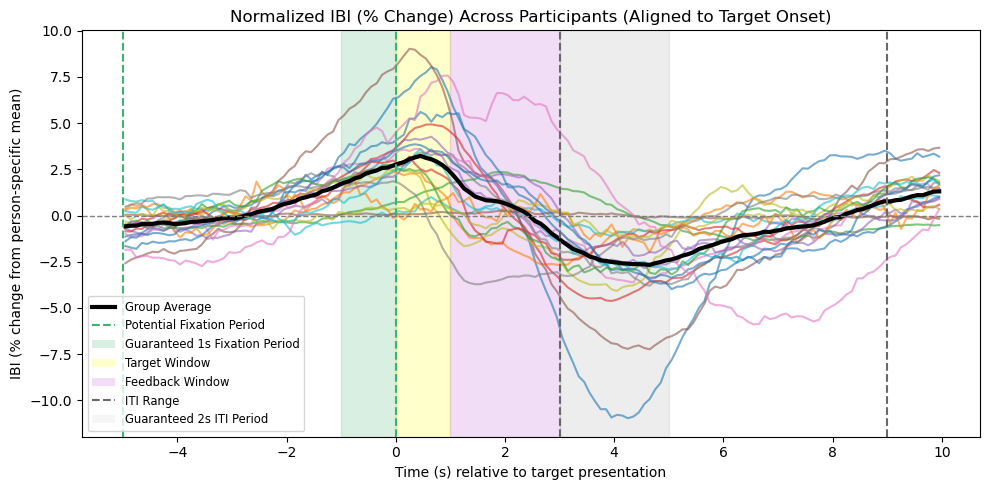

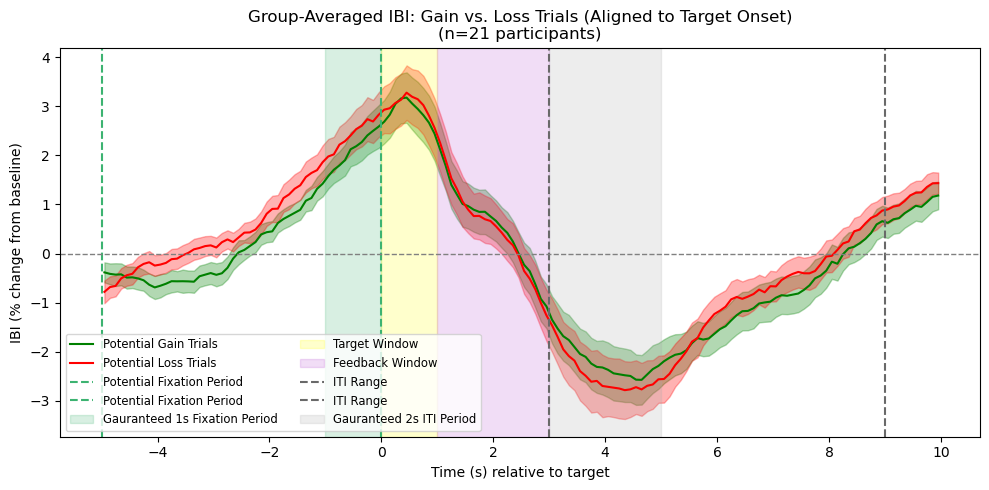

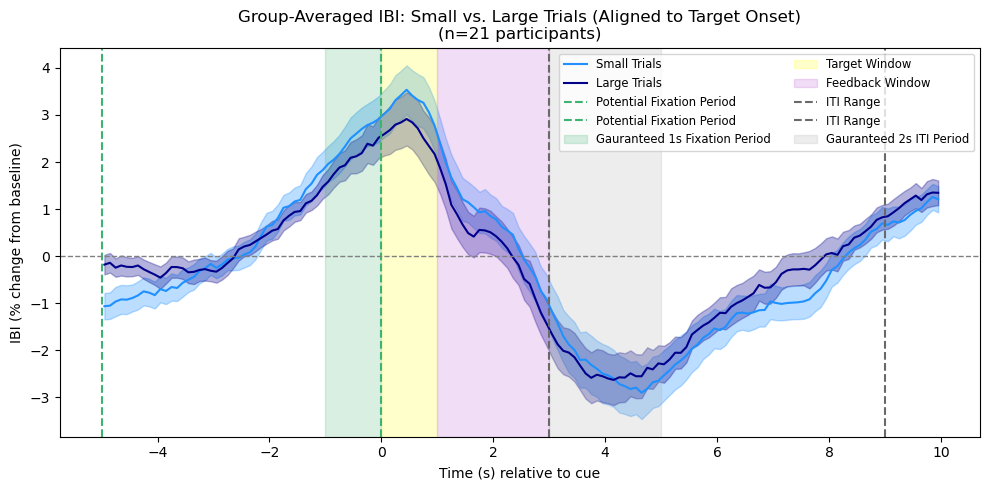

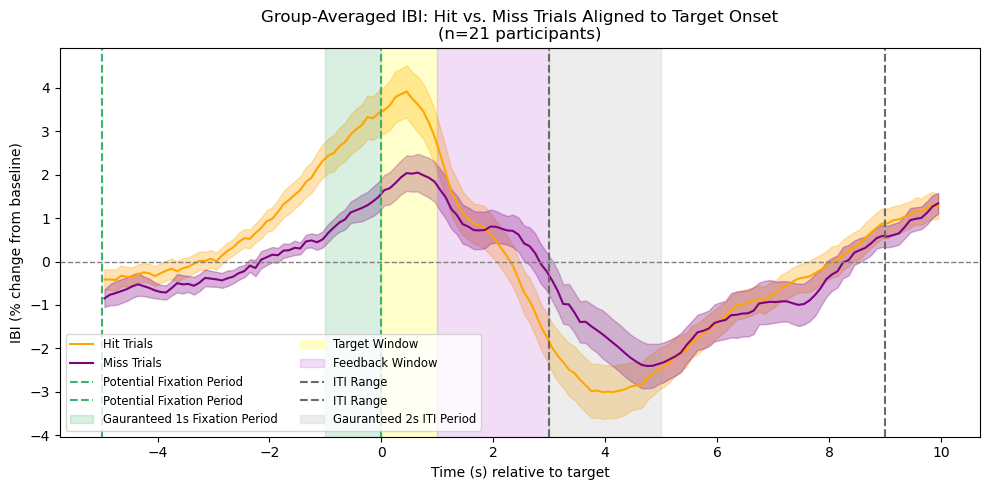

In [432]:
### decide if I want to keep this code block but probably not 
participants = ["4111", "4112", "4113", "4114", "4115", "4117", "4120", "4125", "4127", "4121", "4142", "4139", "4148", "4145", "4152", "4149", "4103",
               "4156", "4160", "4157", "4159"]  

base_path="/restricted/projectnb/cd-lab/yesh/physio/MID"
participant_path = f"{base_path}/Physio_outputs/p{participants}"
peak_base=participant_path
base_dir = "/restricted/projectnb/cd-lab/yesh/physio/MID/DICOMS"
csv_base = "/restricted/projectnb/cd-lab/yesh/physio/MID/CSVs"

all_participant_runs, group_ibi_matrix, bins, participant_means, all_ibi_runs_by_participant, all_peak_times_by_participant, cleaned_dict = run_group_pipeline(participants, base_dir)

## Converting physio data to long format for IBI modeling 
* each row is one time bin -- there are 150 time bins per trials

In [433]:
#Convert physio data to long form for IBI modeling == each row is one time bin (150 time bins per trial)
def convert_runs_to_long(all_ibi_runs_by_participant, participants, cleaned_dict):
    all_subject_ibis_long = []  
    
    for pid, runs in zip(participants, all_ibi_runs_by_participant):
        cleaned = cleaned_dict[pid]
        participant_baseline = participant_means.get(pid, np.nan)

        for run_idx, run_matrix in enumerate(runs):
            n_trials, n_bins = run_matrix.shape
            df = pd.DataFrame(run_matrix, columns=[f"bin_{i}" for i in range(n_bins)])
            df["subject"] = pid
            df["RunNumber"] = run_idx + 1
            
            meta=cleaned[cleaned["RunNumber"]==run_idx+1]
            df["Trial"] = meta["Trial"].values

            df = df.merge(
                cleaned[['RunNumber','Trial','CueType','FixationDuration','EarlyHit']], 
                on=['RunNumber','Trial'],
                how='left'
            )

            df["baseline_IBI"] = participant_baseline

            # new variables
            df["PotentialGain"] = (df["CueType"] > 5).astype(int)

            magnitude_map = {
                1: 1, 6: 1,
                2: 3, 7: 3,
                3: 5, 8: 5,
                4: 7, 9: 7,
                5: 9, 10: 9
            }
            df["Magnitude"] = df["CueType"].map(magnitude_map)

            # time-since-fixation bins
            bin_centers = np.arange(n_bins) * 0.1
            fixation_onset= 2.0

            #create matrix of bin centers for all trials 
            bin_matrix=np.tile(bin_centers, (n_trials,1))

            #time since fixation onset
            time_since_fix_matrix=bin_matrix-fixation_onset
            time_since_fix_matrix[time_since_fix_matrix<0]=0

            #after fixation end = NaN
            fixation_end_matrix=fixation_onset + df["FixationDuration"].values[:,None]
            time_since_fix_matrix[bin_matrix>fixation_end_matrix]=np.nan

            # mask entire trial if EarlyHit is NA
            early_hit_mask = df["EarlyHit"].isna().values[:, None]  # shape (n_trials, 1)
            time_since_fix_matrix = np.where(early_hit_mask, np.nan, time_since_fix_matrix)


            #convert to data frame
            time_since_fix_df=pd.DataFrame(
                time_since_fix_matrix,
                columns=[f"time_since_fix_bin_{i}" for i in range(n_bins)]
            )
            
            df = pd.concat([df, time_since_fix_df], axis=1)
            all_subject_ibis_long.append(df)

    ibi_long = pd.concat(all_subject_ibis_long, ignore_index=True)
    return ibi_long


## Running a paired t-test between groups

In [434]:
def stats_2s(mean_gain_list_norm, mean_loss_list_norm,
             mean_large_list_norm, mean_small_list_norm, 
             mean_posf_list_norm, mean_negf_list_norm,
             bin_centers):

    import numpy as np
    from scipy.stats import ttest_rel

    window = (bin_centers >= 1) & (bin_centers <= 3)
    window_target = (bin_centers >= 0) & (bin_centers <= 1)

    # Convert lists of participant timecourses → arrays
    gain_arr = np.vstack(mean_gain_list_norm)
    loss_arr = np.vstack(mean_loss_list_norm)
    large_arr = np.vstack(mean_large_list_norm)
    small_arr = np.vstack(mean_small_list_norm)
    posf_arr=np.vstack(mean_posf_list_norm)
    negf_arr=np.vstack(mean_negf_list_norm)

    # Average within 0–2s for each participant
    gain_vals = np.nanmean(gain_arr[:, window], axis=1)
    loss_vals = np.nanmean(loss_arr[:, window], axis=1)
    large_vals = np.nanmean(large_arr[:, window], axis=1)
    small_vals = np.nanmean(small_arr[:, window], axis=1)
    posf_vals=np.nanmean(posf_arr[:, window], axis=1)
    negf_vals=np.nanmean(negf_arr[:, window], axis=1)

    gain_vals_f = np.nanmean(gain_arr[:, window_target], axis=1)
    loss_vals_f = np.nanmean(loss_arr[:, window_target], axis=1)
    large_vals_f = np.nanmean(large_arr[:, window_target], axis=1)
    small_vals_f = np.nanmean(small_arr[:, window_target], axis=1)
    posf_vals_f=np.nanmean(posf_arr[:, window_target], axis=1)
    negf_vals_f=np.nanmean(negf_arr[:, window_target], axis=1)


    # Paired t-tests
    t_gain_loss, p_gain_loss = ttest_rel(gain_vals, loss_vals, nan_policy='omit')
    t_large_small, p_large_small = ttest_rel(large_vals, small_vals, nan_policy='omit')
    t_posf_negf, p_posf_negf=ttest_rel(posf_vals, negf_vals, nan_policy="omit")

    t_gain_loss_fb, p_gain_loss_fb = ttest_rel(gain_vals_f, loss_vals_f, nan_policy='omit')
    t_large_small_fb, p_large_small_fb = ttest_rel(large_vals_f, small_vals_f, nan_policy='omit')
    t_posf_negfb, p_posf_negfb=ttest_rel(posf_vals_f, negf_vals_f, nan_policy="omit")


    print("\n===== 0–2s Paired t-tests (During Target Window) =====")
    print(f"Gain vs Loss:   t = {t_gain_loss:.3f}, p = {p_gain_loss:.4f}")
    print(f"Large vs Small: t = {t_large_small:.3f}, p = {p_large_small:.4f}")
    #print(f"Hit vs Miss: t={t_posf_negf:.3f}, p={p_posf_negf:.4f}")
    print("================================\n")

 
    print("\n===== 1–3s Paired t-tests (During Feedback Window) =====")
    print(f"Gain vs Loss:   t = {t_gain_loss_fb:.3f}, p = {p_gain_loss_fb:.4f}")
    print(f"Large vs Small: t = {t_large_small_fb:.3f}, p = {p_large_small_fb:.4f}")
    print(f"Hit vs Miss: t={t_posf_negfb:.3f}, p={p_posf_negfb:.4f}")
    print("================================\n")


    # Return results in case you want to save/log them
    return {
        "gain_loss": (t_gain_loss, p_gain_loss),
        "large_small": (t_large_small, p_large_small),
        "gain_loss_feedback": (t_gain_loss_fb, p_gain_loss_fb),
        "large_small_feedback": (t_gain_loss_fb, p_gain_loss_fb),
        "hit_miss_feedback": (t_posf_negfb, p_posf_negfb)
    }


In [435]:
def print_ttest_result(label, ttest_tuple, n=None):
    """
    Pretty-print a t-test result.

    Parameters
    ----------
    label : str
        Description of the comparison (e.g., "Gain vs Loss – Anticipatory IBI")
    ttest_tuple : tuple
        (t_statistic, p_value)
    n : int, optional
        Sample size (number of participants) for df display
    """
    t, p = ttest_tuple

    if n is not None:
        df = n - 1
        print(f"{label}: t({df}) = {t:.3f}, p = {p:.3g}")
    else:
        print(f"{label}: t = {t:.3f}, p = {p:.3g}")


In [436]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_avg_timecourses_by_participant(participant_avg_timecourses, bin_centers, participants, group_avg=True):
#     """
#     Plots average percent change IBI timecourse per participant.

#     Args:
#         participant_avg_timecourses (list of arrays): One array per participant, each of shape (timepoints,)
#         bin_centers (array): Time axis for the x-axis
#         participants (list): Participant IDs, same order as participant_avg_timecourses
#         group_avg (bool): Whether to overlay the grand average across participants
#     """
#     plt.figure(figsize=(10, 6))

#     for avg_tc, pid in zip(participant_avg_timecourses, participants):
#         plt.plot(bin_centers, avg_tc, alpha=0.4, label=f'{pid}')

#     if group_avg:
#         group_mean = np.nanmean(np.array(participant_avg_timecourses), axis=0)
#         plt.plot(bin_centers, group_mean, color='black', linewidth=2, label='Group Average')
#     annotate_event_timeline()
#     plt.axhline(0, color='gray', linestyle='--', linewidth=1)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Percent Change IBI (%)')
#     plt.title('Average IBI Timecourse per Participant')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
#     plt.tight_layout()
#     plt.show()


## Group Analysis Pipeline -- Condition Specific Baseline Correction

For each participant, raw PPG peak times are first aligned in time to cue onset to construct trial-level, event-related IBI trajectories. In addition to temporal alignment, the pipeline applies a participant- and condition-specific baseline correction using a pre-cue window (–2 to 0 s), ensuring that gain and loss (and small and large magnitude) timecourses enter the anticipatory period from a common baseline level.

At the participant level, the pipeline:
* Loads cleaned behavioral trial data and raw peak time files for each run.
* Generates aligned IBI timecourses around cue onset using a single-participant processing pipeline.
* Extracts gain vs loss and large vs. small magnitude trial subsets.
* Performs participant-specific baseline correction using a pre-cue window (–2 to 0 s) and normalizes all timecourses to percent change from baseline.
* Computes condition-specific mean IBI timecourses for each participant.
* Derives participant-level difference waves for valence (loss – gain) and magnitude (large – small) contrasts.

 **At the group level, the pipeline:** 
*   Aggregates all participant timecourses into a stacked group IBI matrix.
* Generates diagnostic and results plots including:
* Overall IBI timecourse shape around cue onset,
* Gain vs loss comparisons,
* Small vs large magnitude comparisons,
* Group-level difference waves for valence and magnitude.
* Performs paired-sample statistical tests comparing gain vs. loss and large vs. small conditions across participants.


In [437]:
def run_group_pipeline_corrected(participants, base_dir, plot_all=True):
    """
    Runs group level IBI analysis pipeline:
    - Loads multiple participants data and peak times
    - Calculates per-run baselines and normalized metrics 
    - Aggregates group data for plotting and group level analyses
    - Returns raw peak times for optional unaligned IBI analysis
    """
    import traceback
    import os
    import numpy as np

    # initialize storage for group results 
    all_ibi_runs_by_participant = []  # list of per-participant lists of runs (each run is a 2d array)
    all_participant_runs = []  # flattened list of all run data for all participants
    all_peak_times_by_participant = []  #raw peak timestamps for each participant
    cleaned_dict={}

    mean_loss_list = []
    mean_gain_list = []
    mean_loss_list_norm = []
    mean_gain_list_norm = []

    mean_small_list = []
    mean_large_list = []
    mean_small_list_norm = []
    mean_large_list_norm = []
    
    mean_posf_list=[]
    mean_negf_list=[]
    mean_posf_list_norm=[]
    mean_negf_list_norm=[]

    # mean_mag1_list=[]
    # mean_mag3_list=[]
    # mean_mag5_list=[]
    # mean_mag7_list=[]
    # mean_mag9_list=[]

    # mean_ibi_mag1_list_norm=[]
    # mean_ibi_mag3_list_norm=[]
    # mean_ibi_mag5_list_norm=[]
    # mean_ibi_mag7_list_norm=[]
    # mean_ibi_mag9_list_norm=[]

    diff_large_small_list=[]
    diff_loss_gain_list=[]
    diff_hit_miss_list =[]
    
    bin_centers = None
    participant_means = {}  # store person-specific baselines
    gain_means= {}
    loss_means={}

    # iterate over all participants 
    for pid in participants:
        try:
            # Define file paths 
            participant_path = f"{base_path}/Physio_outputs"
            peak_base = participant_path
            print(f"\n--- Starting {pid} ---")
            
            csv_path = os.path.join(csv_base, f"p{pid}_data.csv")
            peak_times_dir = os.path.join(peak_base, f"p{pid}")

            print(f"CSV path: {csv_path}")
            print(f"Peak times dir: {peak_times_dir}")
            
            # Check that csv and peak files exist 
            if not os.path.exists(csv_path):
                print(f"❌ CSV file not found for {pid}")
                continue
            if not os.path.isdir(peak_times_dir):
                print(f"❌ Peak directory not found for {pid}")
                continue
            
            # ---  load raw peak times (unaligned) ---
            peaks_for_participant = load_peak_times(peak_times_dir, n_runs=4)
            all_peak_times_by_participant.append(peaks_for_participant)
            
            # Run single participant pipeline to get aligned IBIs
            all_ibi_runs, bin_centers = run_pipeline_single(
                csv_path=csv_path,
                peak_times_dir=peak_times_dir,
                plot_run=None,
                plot_n_trials=0,
                plot_group_average=False,
                plot_task_average=False,
                plot_gainloss=False,
                plot_smalllarge=False,
                plot_magnitudes_flag=False,
                plot_hitmiss_flag = False
            )
            
            all_ibi_runs_by_participant.append(all_ibi_runs)

            # Stack all runs for this participant into a 2d array
            participant_ibi = np.vstack(all_ibi_runs)

            if participant_ibi.size == 0:
                print(f"No IBI data for participant {pid}")
                continue

        
            # Compute person-specific baseline
            #participant_mean_ibi = np.nanmean(participant_ibi)
            #participant_means[pid] = participant_mean_ibi

            # Load cleaned csv - early hit trials removed  
            cleaned = load_data(csv_path)
            cleaned_dict[pid]=cleaned

            ## --- Trial type averages and normalizations ----
            # Gain/Loss
            mean_ibi_loss, mean_ibi_gain, loss_trials, gain_trials = gainorloss(cleaned, participant_ibi)

            #participant x condition specific baseline to baseline correct 
            baseline_window=(bin_centers >= -2) & (bin_centers <=-0)
            baseline_window_feedback = (bin_centers >= 0.6) & (bin_centers <=1)
            
            #Gain/Loss Corrected
            #establishing the baseline window
            gain_baseline=np.nanmean(gain_trials[:, baseline_window])
            loss_baseline=np.nanmean(loss_trials[:, baseline_window])

            #baseline correcting the trials
            gain_corrected_tc=gain_trials-gain_baseline
            loss_corrected_tc=loss_trials-loss_baseline

            #getting the mean timecourse of the corrected trials 
            mean_ibi_gain_corrected=np.nanmean(gain_corrected_tc, axis=0)
            mean_ibi_loss_corrected=np.nanmean(loss_corrected_tc, axis=0)

            #normalizing the time course 
            mean_ibi_gain_corrected_norm=(mean_ibi_gain_corrected/ gain_baseline) * 100
            mean_ibi_loss_corrected_norm=(mean_ibi_loss_corrected / loss_baseline) * 100
            
            #Store 
            mean_loss_list.append(mean_ibi_loss_corrected)
            mean_gain_list.append(mean_ibi_gain_corrected)
            mean_loss_list_norm.append(mean_ibi_loss_corrected_norm)
            mean_gain_list_norm.append(mean_ibi_gain_corrected_norm)

            gain_means[pid]=gain_baseline
            loss_means[pid]=loss_baseline

            #Big/Small Corrected
            mean_ibi_large, mean_ibi_small, large_trials, small_trials = smallorlarge(cleaned, participant_ibi)
            #establishing the baseline window
            large_baseline=np.nanmean(large_trials[:, baseline_window])
            small_baseline=np.nanmean(small_trials[:,baseline_window])
            
            #baseline correcting the trials
            large_corrected_tc=large_trials-large_baseline
            small_corrected_tc=small_trials-small_baseline

            #mean time course of corrected trials 
            mean_ibi_large_corrected=np.nanmean(large_corrected_tc, axis=0)
            mean_ibi_small_corrected=np.nanmean(small_corrected_tc, axis=0)

            #normalizing the tc to be in % change
            mean_ibi_large_corrected_norm=(mean_ibi_large_corrected / large_baseline) *100
            mean_ibi_small_corrected_norm=(mean_ibi_small_corrected / small_baseline) * 100

            #Store
            mean_large_list.append(mean_ibi_large_corrected)
            mean_small_list.append(mean_ibi_small_corrected)
            mean_large_list_norm.append(mean_ibi_large_corrected_norm)
            mean_small_list_norm.append(mean_ibi_small_corrected_norm)

            #Hit vs Miss
            mean_ibi_posfeedback,mean_ibi_negfeedback, posfeedback_trials, negfeedback_trials = pos_or_neg_feedback(cleaned, participant_ibi)

            #establishing the baseline window for baseline correction 
            posf_baseline=np.nanmean(posfeedback_trials[:,baseline_window_feedback])
            negf_baseline=np.nanmean(negfeedback_trials[:,baseline_window_feedback])

            #baseline correcting the time courses 
            posf_corrected_tc= posfeedback_trials-posf_baseline
            negf_corrected_tc= negfeedback_trials - negf_baseline

            #mean timecourse of the baseline corrected trials 
            mean_ibi_posf_corrected=np.nanmean(posf_corrected_tc, axis=0)
            mean_ibi_negf_corrected=np.nanmean(negf_corrected_tc, axis=0)

            #normalizing the timecourse to be represented in percent tange 
            mean_ibi_posf_corrected_norm=(mean_ibi_posf_corrected/posf_baseline) * 100
            mean_ibi_negf_corrected_norm=(mean_ibi_negf_corrected/negf_baseline) * 100

            #Store
            mean_posf_list.append(mean_ibi_posf_corrected)
            mean_negf_list.append(mean_ibi_negf_corrected)
            mean_posf_list_norm.append(mean_ibi_posf_corrected_norm)
            mean_negf_list_norm.append(mean_ibi_negf_corrected_norm)

            #Difference waves
            #small vs large 
            diff_large_small=mean_ibi_large_corrected_norm - mean_ibi_small_corrected_norm
            diff_loss_gain=mean_ibi_loss_corrected_norm-mean_ibi_gain_corrected_norm
            #diff_hit_miss=mean_ibi_negf_corrected_norm-mean_ibi_posf_corrected_norm
            diff_hit_miss=mean_ibi_posf_corrected_norm-mean_ibi_negf_corrected_norm

            diff_large_small_list.append(diff_large_small)
            diff_loss_gain_list.append(diff_loss_gain)
            diff_hit_miss_list.append(diff_hit_miss)

            all_participant_runs.append(participant_ibi)

        except Exception as e:
            print(f"Failed to process {pid}: {e}")
            traceback.print_exc()

    if not all_participant_runs:
        print("No participant data found — cannot stack arrays.")
        return None, None, None, None, None, None

    # Stack all participants' data vertically (all trials from all participants)
    group_ibi_matrix = np.vstack(all_participant_runs)

    if plot_all:
        #plot_4_runs_by_participant(all_ibi_runs_by_participant, bin_centers, participants, participant_means)
        #is_consistent_across_runs(all_ibi_runs_by_participant, bin_centers, participant_means, participants)
        what_shape_cue_presentation(all_participant_runs, bin_centers, participants)
        is_difference_gain_vs_loss(mean_loss_list_norm, mean_gain_list_norm, bin_centers, participants)
        is_difference_small_vs_large(mean_large_list_norm, mean_small_list_norm, bin_centers, participants)
        is_difference_hit_miss(mean_posf_list_norm, mean_negf_list_norm, bin_centers,participants)
        plot_group_diff_waves(diff_large_small_list, diff_loss_gain_list, diff_hit_miss_list, bin_centers, participants)
        #plot_group_magnitudes(mean_ibi_mag1_list_norm, mean_ibi_mag3_list_norm, mean_ibi_mag5_list_norm, mean_ibi_mag7_list_norm, mean_ibi_mag9_list_norm, bin_centers, participants)

    tresults=stats_2s(mean_gain_list_norm, mean_loss_list_norm, mean_large_list_norm, mean_small_list_norm, mean_posf_list_norm, mean_negf_list_norm, bin_centers)

    # return (
    #     all_participant_runs,            # aligned and stacked
    #     group_ibi_matrix, 
    #     bin_centers, 
    #     participant_means, 
    #     all_ibi_runs_by_participant,     # aligned per run
    #     all_peak_times_by_participant,
    #     cleaned_dict
    #       )

    results_corrected={
    "participants": participants, 
    "all_participant_runs": all_participant_runs,
    "group_ibi_matrix": group_ibi_matrix,
    "bin_centers": bin_centers,
    "participant_means": participant_means,
    "ibi_runs_by_participant": all_ibi_runs_by_participant,
    "peak_times_by_participant": all_peak_times_by_participant,
    "mean_loss": mean_loss_list_norm,
    "mean_gain": mean_gain_list_norm,
    "mean_large": mean_large_list_norm,
    "mean_small": mean_small_list_norm,
    "diff_size": diff_large_small_list,
    "diff_val": diff_loss_gain_list,
    "diff_outcome": diff_hit_miss_list,
    "mean_hit": mean_posf_list_norm,
    "mean_miss": mean_negf_list_norm,
    "tresults": tresults,
    "cleaned_dict": cleaned_dict,
    }
    return results_corrected



--- Starting 4111 ---
CSV path: /restricted/projectnb/cd-lab/yesh/physio/MID/CSVs/p4111_data.csv
Peak times dir: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r4.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r1.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r2.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_outputs/p4111/peakTimes_PPG_Siemens_col_r3.txt
Loading: /restricted/projectnb/cd-lab/yesh/physio/MID/Physio_out

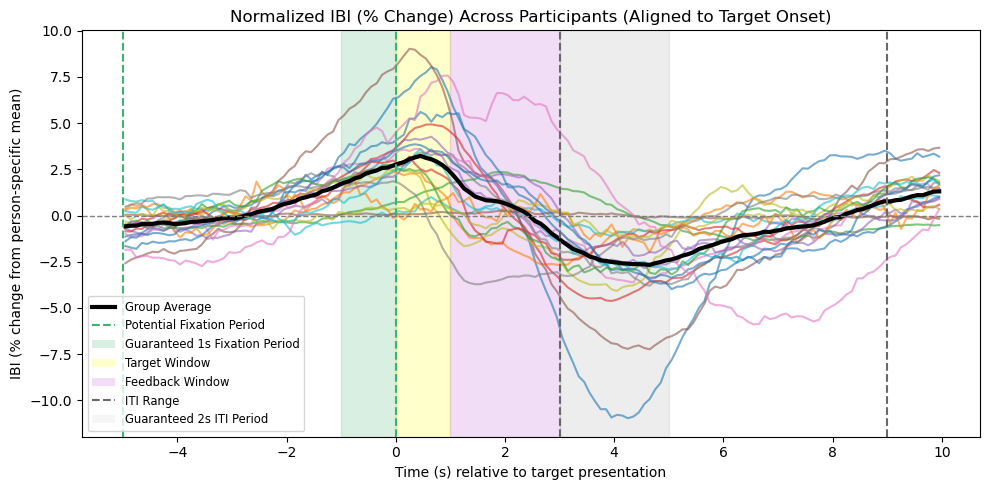

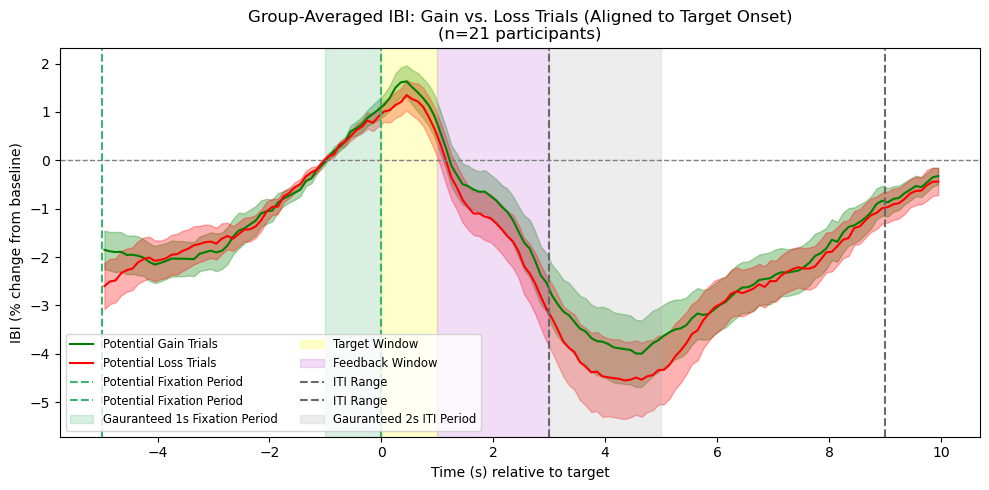

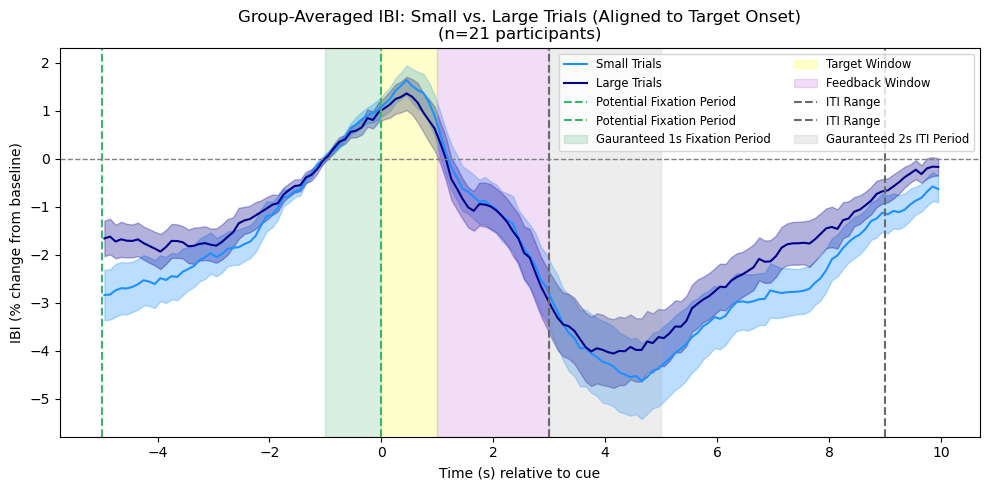

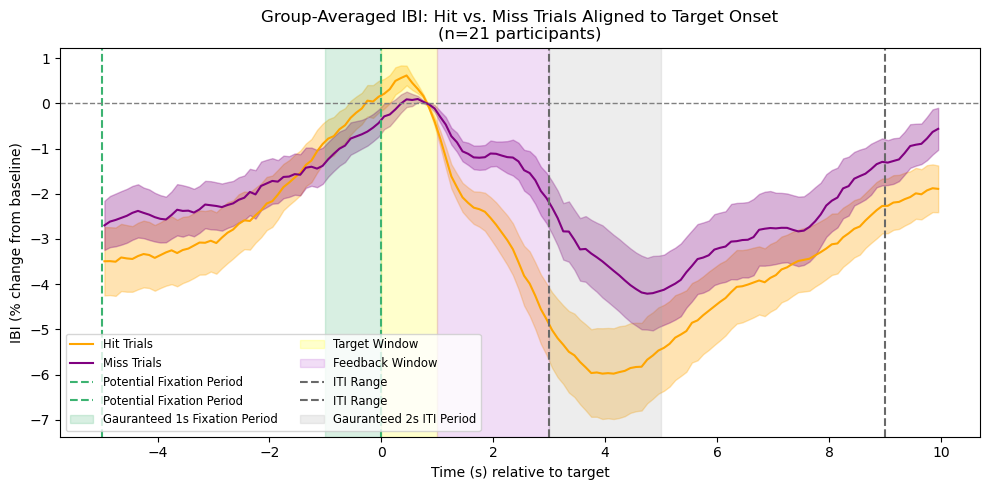

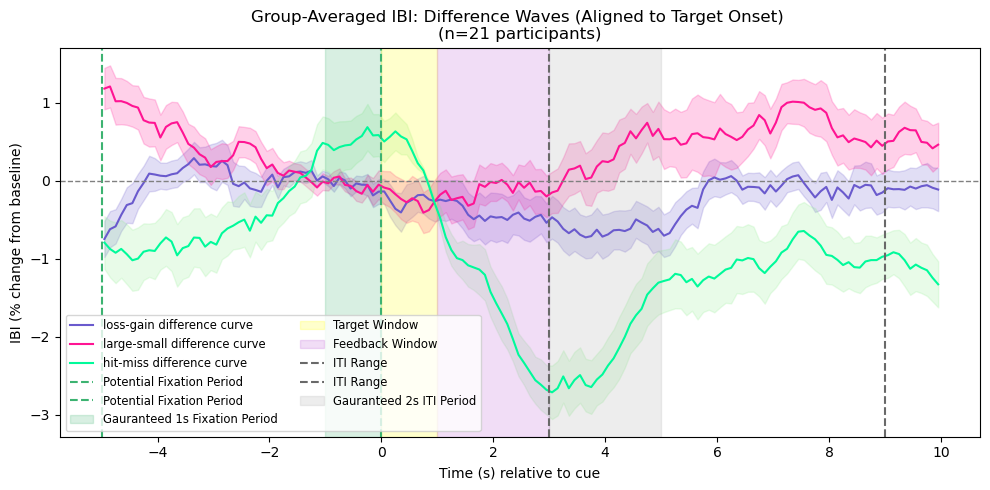


===== 0–2s Paired t-tests (During Target Window) =====
Gain vs Loss:   t = 1.732, p = 0.0986
Large vs Small: t = -0.560, p = 0.5814


===== 1–3s Paired t-tests (During Feedback Window) =====
Gain vs Loss:   t = 1.246, p = 0.2273
Large vs Small: t = -1.075, p = 0.2950
Hit vs Miss: t=2.505, p=0.0210



In [438]:
results_corrected = run_group_pipeline_corrected(participants, base_dir)

## Converting IBI-time bin data to long form for modeling 

In [439]:
ibi_long=convert_runs_to_long(all_ibi_runs_by_participant, participants, cleaned_dict)
ibi_long.to_csv("group_IBI_trials_target.csv", index=False) 

# Results

## How does IBI dynamically change around cue presentation in the MID task?
* Pre-target anticipatory rise (~ -1 to 0s): IBI gradually increases across the 1s fixation period which may suggest cardiac slowing as participants anticipate the target presentation
* Target and post-target deceleration (~1 to 5s): after the presentation of the target, IBI starts dropping quite rapidly and continues to drop into the IBI period. This indicates that HR increases as a response to the target presentation and feedback presentation. 

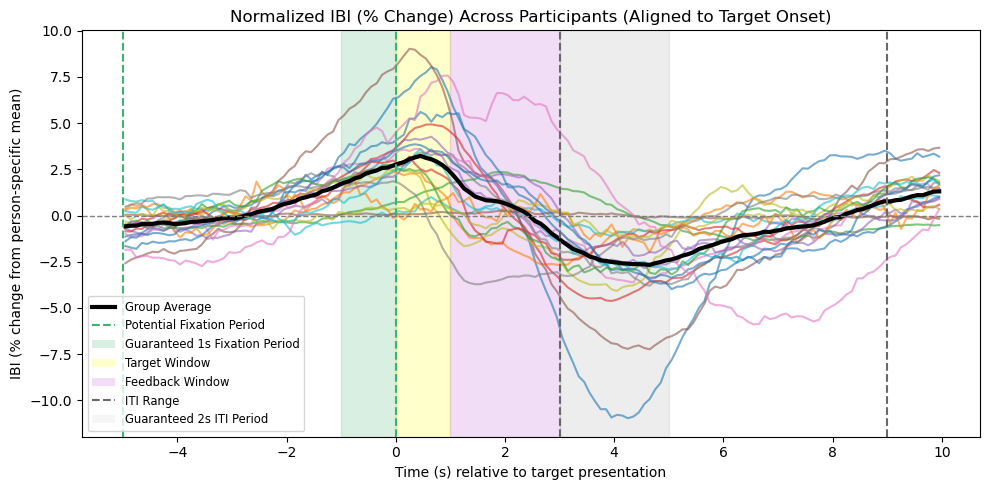

In [440]:
def plot_shape_from_results(results):
    what_shape_cue_presentation(
        results["all_participant_runs"],
        results["bin_centers"],
        participants
    )

plot_shape_from_results(results_corrected)

## Do participants' IBI timecourses differ between potential gain and loss trials?
* The IBI timecourse (averaged across participants) is consistent when presented with potential gain or potential loss cue types

The t-test tests if there is statistically significant difference between the mean IBI in the two different conditions. The t-tests suggest that there is no statistically significant in the mean IBI between gain and loss trials in the 1s target presentation window, nor in the 2s feedback window

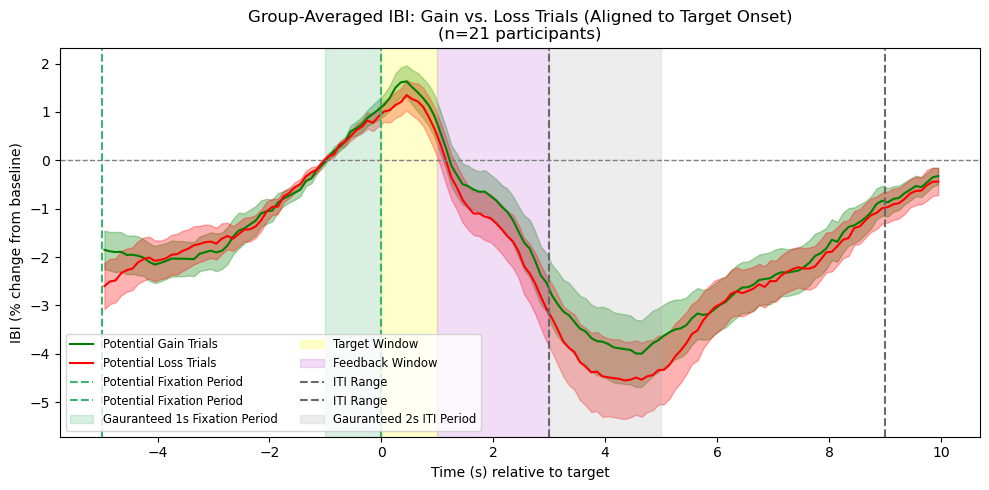

In [441]:
def plot_gain_and_loss(results):
    is_difference_gain_vs_loss(
        results["mean_loss"],
        results["mean_gain"],
        results["bin_centers"],
        participants
    )

plot_gain_and_loss(results_corrected)

In [442]:
tresults = results_corrected["tresults"]

print_ttest_result(
    "Gain vs Loss IBI During 1s Target Window",
    tresults["gain_loss"],
    n=len(results_corrected["mean_gain"])
)

print_ttest_result(
    "Gain vs Loss IBI During 2s Feedback Period",
    tresults["gain_loss_feedback"],
    n=len(results_corrected["mean_gain"])
)


Gain vs Loss IBI During 1s Target Window: t(20) = 1.732, p = 0.0986
Gain vs Loss IBI During 2s Feedback Period: t(20) = 1.246, p = 0.227


## Do participants' IBI timecourses differ between small and large trial types? 

The plots suggest there is not a big difference in the IBI changes during target presentation or feedback presentation between the small trials (magnitude 1 dollar and 3 dollar) vs the large trials (magnitude7 dollars and 9 dollars). 

The paired t-test suggests that there are differences between the two groups but not yet at a statistically significant level. 

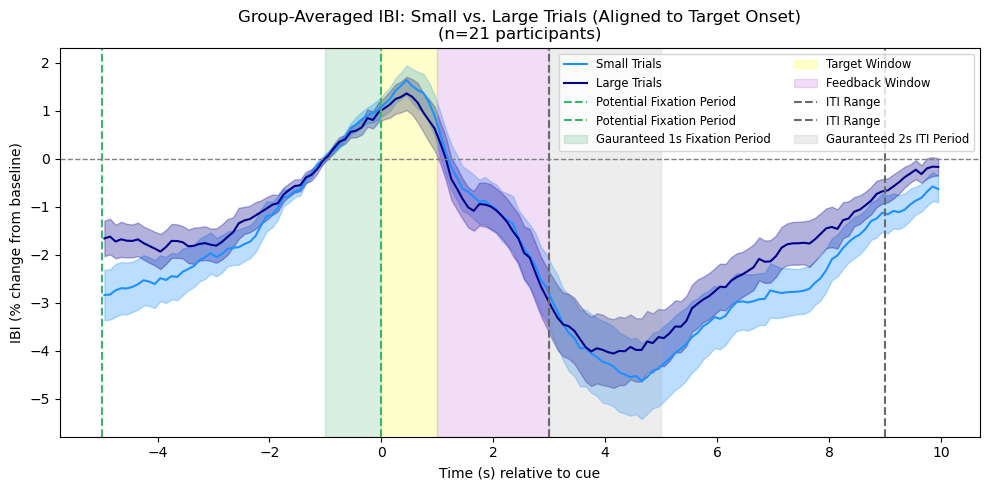

In [443]:
def plot_big_and_small(results):
    is_difference_small_vs_large(
        results["mean_large"],
        results["mean_small"],
        results["bin_centers"],
        participants
    )
plot_big_and_small(results_corrected)

In [444]:
tresults = results_corrected["tresults"]

print_ttest_result(
    "Large vs Small IBI During 1s Target Window",
    tresults["large_small"],
    n=len(results_corrected["mean_gain"])
)


print_ttest_result(
    "Large vs Small IBI During 2s Feedback Period",
    tresults["large_small_feedback"],
    n=len(results_corrected["mean_gain"])
)

Large vs Small IBI During 1s Target Window: t(20) = -0.560, p = 0.581
Large vs Small IBI During 2s Feedback Period: t(20) = 1.246, p = 0.227


## Do participants' IBI timecourses in the feedback window differ between hit and miss trial types? 
Yes! In the feedback window (purple region), IBI decreases more steeply, suggesting that there may be slightly different physiological responses to hit and miss trials. Heart rate seems to increase more for hit trials versus miss trials in the feedback window. 

Additionally, the t-test suggests that the mean IBI during the feedback window is different between hit and miss trials at a statistically significant level. 

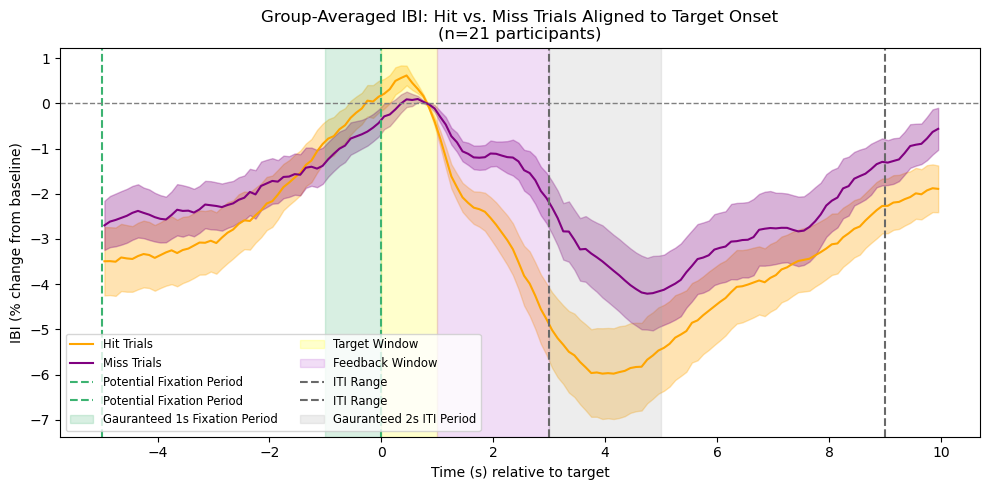

In [445]:
def plot_hit_and_miss(results):
    is_difference_hit_miss(
        results["mean_hit"],
        results["mean_miss"],
        results["bin_centers"],
        participants
    )
plot_hit_and_miss(results_corrected)

In [446]:
print_ttest_result(
    "Hit vs Miss IBI During 2s Feedback Period",
    tresults["hit_miss_feedback"],
    n=len(results_corrected["mean_gain"])
)

Hit vs Miss IBI During 2s Feedback Period: t(20) = 2.505, p = 0.021


## Do difference waves suggest any meaningful effects of cue valence, magnitude, or feedback on the participant-averaged IBI timecourse?
* Perhaps yes! The difference curve plot shows that average IBI falls up to 3% faster across the 2s feedback window range when participants see positive feedback (hit) vs negative feedback (miss)

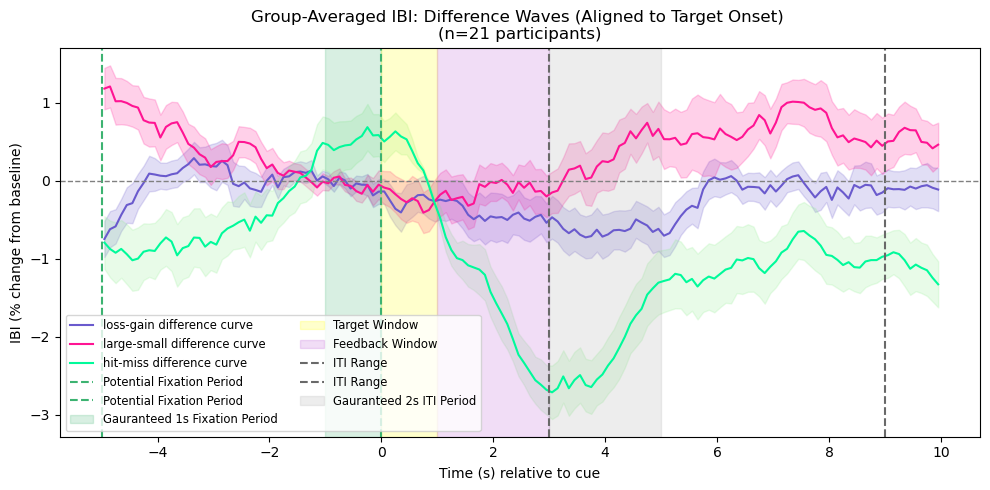

In [447]:
def plot_diff_waves(results):
    plot_group_diff_waves(
        results["diff_size"],
        results["diff_val"],
        results["diff_outcome"],
        results["bin_centers"],
        participants
    )

plot_diff_waves(results_corrected)